In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf
import yfinance as yf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
leverage_ratio = 3

ETF = 'NDX'
ETF_3x = 'TQQQ'

In [4]:
qqq = yf.Ticker(ETF).history(
    period='max', 
    interval='1d', 
    actions=False)

In [5]:
qqq = qqq.reset_index()
qqq['id'] = qqq.index
qqq['Date'] = pd.to_datetime(qqq['Date']).dt.date

In [6]:
qqq.head(3)

,Date,Open,High,Low,Close,Volume,id
0,1985-10-01,110.620003,112.160004,110.565002,112.139999,153160000,0
1,1985-10-02,112.139999,112.540001,110.779999,110.824997,164640000,1
2,1985-10-03,110.839996,111.184998,110.120003,110.870003,147300000,2


In [7]:
qqq = pysqldf(u"""
    select qqq.*, 
    pre_day.Date as pre_Date,
    pre_day.Close as pre_Close,
    (qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
    from qqq 
    left join qqq as pre_day on pre_day.id+1 = qqq.id
    order by qqq.Date asc
    """)

In [8]:
pysqldf(u"""
    select * 
    from qqq
    order by Date asc
    limit 3
    """)

,Date,Open,High,Low,Close,Volume,id,pre_Date,pre_Close,Percent
0,1985-10-01,110.620003,112.160004,110.565002,112.139999,153160000,0,None,NaN,NaN
1,1985-10-02,112.139999,112.540001,110.779999,110.824997,164640000,1,1985-10-01,112.139999,-0.011726
2,1985-10-03,110.839996,111.184998,110.120003,110.870003,147300000,2,1985-10-02,110.824997,0.000406


In [9]:
data_list = pysqldf(u"""
    select 
    Date,
    Percent, 
    {}*Percent as Leveraged_Percent
    from qqq
    where Percent is not null
    """.format(leverage_ratio)).to_dict('records')

In [10]:
data_list[0:3]

[{'Date': '1985-10-02',
  'Percent': -0.011726435246687159,
  'Leveraged_Percent': -0.03517930574006148},
 {'Date': '1985-10-03',
  'Percent': 0.0004060978983005295,
  'Leveraged_Percent': 0.0012182936949015886},
 {'Date': '1985-10-04',
  'Percent': -0.0071706122363594214,
  'Leveraged_Percent': -0.021511836709078264}]

In [11]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

tqqq vs 3x qqq

In [13]:
data_3x = yf.Ticker(ETF_3x).history(
    period='max', 
    interval='1d', 
    actions=False)

In [14]:
data_3x = data_3x.reset_index()
data_3x['id'] = data_3x.index
data_3x['Date'] = pd.to_datetime(data_3x['Date']).dt.date

In [15]:
data_3x.head(3)

,Date,Open,High,Low,Close,Volume,id
0,2010-02-11,0.403763,0.431569,0.402471,0.429243,3456000,0
1,2010-02-12,0.417562,0.434722,0.415133,0.431001,8601600,1
2,2010-02-16,0.441131,0.448729,0.434205,0.447695,9619200,2


In [16]:
compare_3x = pysqldf(u"""
    select 
    data1.Date,
    data1.`Leveraged_price`,
    data_3x.Close
    from data_3x
    join data1 on data1.Date = data_3x.Date
    order by data1.Date asc
    """.format(leverage_ratio))

# regression

In [17]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [18]:
reg = LinearRegression().fit(X, y)

In [19]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.00044297]
0.2202383221324542


In [20]:
result = pysqldf(u"""
    select 
    Date,
    `Leveraged_price` * {} + {} AS simulated_Close,
    Close
    from compare_3x
    """.format(
    reg.coef_[0],
    reg.intercept_))

all simulation results

In [28]:
data = pysqldf(f"""
    select 
    data1.Date,
    data1.price AS {ETF},
    data1.`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS Close,
    data_3x.Close as {ETF_3x}
    from data1
    left join data_3x on data_3x.Date = data1.Date
    """)

In [31]:
data = data.reset_index()
data['id'] = data.index

In [32]:
data

,index,Date,NDX,Close,TQQQ,id
0,0,1985-10-02,110.824997,0.268166,NaN,0
1,1,1985-10-03,110.870003,0.268224,NaN,1
2,2,1985-10-04,110.074997,0.267192,NaN,2
3,3,1985-10-07,108.199997,0.264793,NaN,3
4,4,1985-10-08,107.160004,0.263508,NaN,4
...,...,...,...,...,...,...
9400,9400,2023-01-19,11295.669922,19.934403,18.850000,9400
9401,9401,2023-01-20,11619.030273,21.627471,20.389999,9401
9402,9402,2023-01-23,11872.540039,23.028692,21.730000,9402
9403,9403,2023-01-24,11846.639648,22.879419,21.600000,9403


<AxesSubplot: xlabel='Date'>

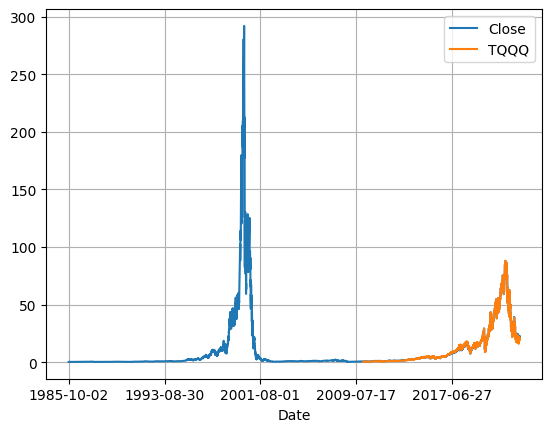

In [30]:
data.plot(x ='Date', y=[
    'Close'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

END